## Import libs

In [1]:
import numpy as np
import seaborn as sb
%matplotlib inline 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import confusion_matrix
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA as PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from time import time

import os
import cv2

## Dataset class for data processing

In [2]:
class Dataset():
    def __init__(self, data_path, transform) -> None:
        self.data_path = data_path
        self.transform = transform
        self.image_pairs = []
        self.labels = []

    def get_all_data(self):
        all_pairs = []
        for label in os.listdir(self.data_path):
            image_data_dir = os.path.join(self.data_path, label)
            for pair_dir in os.listdir(image_data_dir):
                identity_photos_dir = os.path.join(image_data_dir, pair_dir)
                pair = os.listdir(identity_photos_dir)
                pair_tuple = (os.path.join(identity_photos_dir, pair[0]), os.path.join(identity_photos_dir, pair[1]))
                self.image_pairs.append(pair_tuple)
                self.labels.append(label)
                all_pairs.append({'img1':os.path.join(identity_photos_dir, pair[0]), 'img2':os.path.join(identity_photos_dir, pair[1]), label: label})
        
        return all_pairs

    def get_item(self, idx):
        img1_path, img2_path = self.image_pairs[idx]
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)
        
        def transform_img(img, size=(48,48)):
            grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resize_img = cv2.resize(grey_img, size)
            normalized_img = cv2.normalize(resize_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            return normalized_img
            
        if self.transform:
            return transform_img(img1), transform_img(img2), self.labels[idx]
        
        return img1, img2, self.label[idx]
    
    def calc_dist_euclidean(self, img1, img2):
        distance = np.sqrt(np.sum((img1-img2)**2))
        return distance
    
    def calc_dist_simi(self, img1, img2):
        return ssim(img1, img2, data_range=img1.max()-img1.min())
    
    def calc_dist_absolute(self, img1, img2):
        return np.sum(np.absolute(img1-img2))
    
    def calc_dist_cosine(self, img1, img2):
        return np.dot(img1, img2)/(np.linalg.norm(img1) - np.linalg.norm(img2))
    
    def __len__(self):
        return len(self.image_pairs)

## get data

In [3]:
data_path = '../data/'
dataset = Dataset(data_path, transform=True)
all_data = dataset.get_all_data()

## Reduction of features with PCA

In [4]:
n_components = 4
pca = PCA(n_components=n_components)

def reduced_size(pca, all_data, dataset):
    reduced_data = []
    labels = []
    def img_to_pca(pca, img):
        reduced_img = pca.fit_transform(img)
        return reduced_img.flatten()
    start = time()
    for i in range(len(all_data)):
        if i%100 == 0: print(i, "time: ", time()-start )
        img1, img2, label = dataset.get_item(i)
        reduced_img1 = img_to_pca(pca, img1)
        reduced_img2 = img_to_pca(pca, img2)
        reduced_pair = np.concatenate((reduced_img1, reduced_img2))
        reduced_data.append(reduced_pair)
        labels.append(label)
    print("done")
    return np.array(reduced_data), np.array(labels)

X_reduced, y = reduced_size(pca, all_data, dataset)

0 time:  1.6689300537109375e-06
100 time:  0.5193827152252197
200 time:  1.1172151565551758
300 time:  1.5771045684814453
400 time:  2.122969150543213
500 time:  2.5945794582366943
600 time:  2.969301223754883
700 time:  3.4893195629119873
800 time:  3.882253408432007
900 time:  4.365117073059082
1000 time:  4.808045148849487
1100 time:  5.1725544929504395
1200 time:  5.710662841796875
1300 time:  6.075831413269043
1400 time:  6.430253744125366
1500 time:  7.0274269580841064
1600 time:  7.427687644958496
1700 time:  7.919134140014648
1800 time:  8.291093111038208
1900 time:  8.646076202392578
2000 time:  9.137567281723022
2100 time:  9.53778862953186
2200 time:  9.916636228561401
2300 time:  10.422170400619507
2400 time:  10.795589685440063
2500 time:  11.3802649974823
2600 time:  11.766324281692505
2700 time:  12.169508457183838
2800 time:  12.722347259521484
2900 time:  13.09130048751831
3000 time:  13.704160451889038
3100 time:  14.088526964187622
3200 time:  14.457083702087402
3300

## Data split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.15, random_state=42)
print(len(X_train), len(X_test))
print(X_train.shape)

42500 7500
(42500, 384)


## Training

In [51]:
clf = KNN(n_neighbors=20, metric='l2', weights='uniform', algorithm='auto')
clf = clf.fit(X_train, y_train)

import pickle
with open('knn_model_best.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [52]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.55      0.55      3729
           1       0.55      0.55      0.55      3771

    accuracy                           0.55      7500
   macro avg       0.55      0.55      0.55      7500
weighted avg       0.55      0.55      0.55      7500



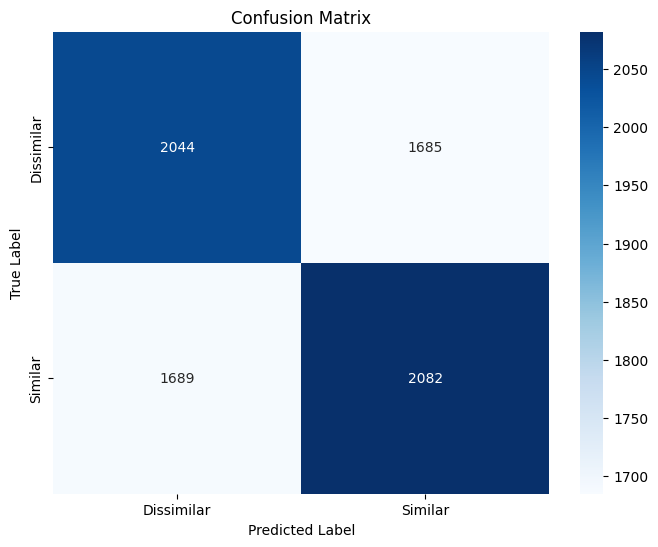

In [53]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Dissimilar', 'Similar'], yticklabels=['Dissimilar', 'Similar'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [54]:
print("acc: ", accuracy_score(y_test, y_pred))
#print(y_pred)
#print(y_test)
print("f1_score: ", f1_score(y_test, y_pred, pos_label='1'))
print("precision: ", precision_score(y_test, y_pred, pos_label='1'))
print("recall: ", recall_score(y_test, y_pred, pos_label='1'))

acc:  0.5501333333333334
f1_score:  0.5524011674184134
precision:  0.5526944518184231
recall:  0.5521081941129674


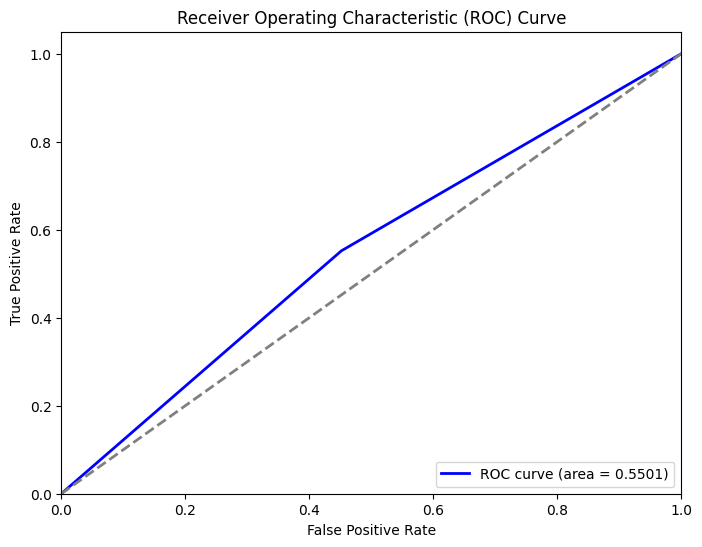

In [55]:
fpr, tpr, _ = roc_curve(y_test.astype(int), y_pred.astype(int))
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()